# Using Transformers from Huggingface
This is an example notebook of how to use Huggingface models with ZnNL

In [46]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import znnl as nl

import numpy as np
import optax

from znnl.models import HuggingFaceFlaxModel
from transformers import ResNetConfig, FlaxResNetForImageClassification
import jax
print(jax.default_backend())

gpu


In [47]:
data_generator = nl.data.CIFAR10Generator(50)

# Input data needs to have shape (num_points, channels, height, width)
train_ds={"inputs": np.swapaxes(data_generator.train_ds["inputs"], 1, 3), "targets": data_generator.train_ds["targets"]}
test_ds={"inputs": np.swapaxes(data_generator.test_ds["inputs"], 1, 3), "targets": data_generator.test_ds["targets"]}

data_generator.train_ds = train_ds
data_generator.test_ds = test_ds

# Execute

In [48]:
# Two standard ResNet architectures

resnet50_config = ResNetConfig(
    num_channels = 3,
    embedding_size = 64, 
    hidden_sizes = [256, 512, 1024, 2048], 
    depths = [3, 4, 6, 3], 
    layer_type = 'bottleneck', 
    hidden_act = 'relu', 
    downsample_in_first_stage = False, 
    out_features = None, 
    out_indices = None, 
    id2label = dict(zip(np.arange(10), np.arange(10))), # Dummy labels to define the output dimension
    return_dict = True,
)

# ResNet-18 taken from https://huggingface.co/microsoft/resnet-18/blob/main/config.json
resnet18_config = ResNetConfig(
    num_channels = 3,
    embedding_size = 64, 
    hidden_sizes = [64, 128, 256, 512], 
    depths = [2, 2, 2, 2], 
    layer_type = 'basic', 
    hidden_act = 'relu', 
    downsample_in_first_stage = False, 
    id2label = dict(zip(np.arange(10), np.arange(10))), # Dummy labels to define the output dimension
    return_dict = True,
)

In [49]:
# From scratch

resnet_config = ResNetConfig(
    num_channels = 3,
    embedding_size = 24, 
    hidden_sizes = [12, 12, 12], 
    depths = [3, 4, 6], 
    layer_type = 'basic', 
    hidden_act = 'relu', 
    downsample_in_first_stage = False, 
    out_features = None, 
    out_indices = None, 
    id2label = dict(zip(np.arange(10), np.arange(10))), # Dummy labels to define the output dimension
    return_dict = True,
)


model = FlaxResNetForImageClassification(
    config=resnet_config,
    input_shape=(1, 32, 32, 3),
    seed=0,
    _do_init = True,
)

znnl_model = HuggingFaceFlaxModel(
    model, 
    optax.adam(learning_rate=0.001),
    store_on_device=False,
)

In [50]:
model = FlaxResNetForImageClassification(
    config=resnet_config,
    input_shape=(1, 32, 32, 3),
    seed=0,
    _do_init = True,
)

out, batch_stats = model(
    data_generator.train_ds["inputs"], 
    train=True, 
)
out.logits, batch_stats

(Array([[-1.04127789e+00,  2.43051744e+00, -2.98134422e+00,
         -3.44487572e+00,  2.17235255e+00, -2.24565554e+00,
          4.27615547e+00,  6.20725584e+00,  1.77270830e+00,
         -1.24137831e+00],
        [-1.56138575e+00,  7.67226517e-01, -2.03905630e+00,
         -1.58136141e+00,  1.16984320e+00, -1.21417797e+00,
          3.35395527e+00,  2.26996398e+00,  1.62532341e+00,
          1.94465891e-02],
        [-7.98286140e-01,  4.58358288e-01, -2.17985201e+00,
         -9.96839643e-01,  3.16030502e-01, -2.34055296e-01,
          1.96459961e+00,  1.46054375e+00, -1.57126501e-01,
         -3.65650833e-01],
        [-1.40896249e+00,  1.83953702e+00, -2.48700881e+00,
         -3.18015742e+00,  2.33244228e+00, -1.02915215e+00,
          3.06305408e+00,  5.04318047e+00,  1.97152519e+00,
          4.54366595e-01],
        [-1.79014885e+00,  8.41565058e-02, -2.22578526e+00,
         -2.04926357e-01,  8.56991172e-01, -2.30062142e-01,
          2.47416258e+00,  9.81130362e-01,  8.815832

In [51]:
train_recorder = nl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    accuracy=True,
    ntk=True,
    covariance_entropy=True,
    magnitude_variance=True, 
    trace=True,
    loss_derivative=True,
    update_rate=1, 
    chunk_size=1000,
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)

trainer = nl.training_strategies.SimpleTraining(
    model=znnl_model, 
    loss_fn=nl.loss_functions.CrossEntropyLoss(),
    accuracy_fn=nl.accuracy_functions.LabelAccuracy(),
    recorders=[train_recorder],
)

In [52]:
batch_wise_training_metrics = trainer.train_model(
    train_ds=data_generator.train_ds,
    test_ds=data_generator.test_ds,
    batch_size=100,
    epochs=200,
)

Epoch: 200: 100%|███████████████████████████████| 200/200 [01:24<00:00,  2.37batch/s, accuracy=0.16]


In [53]:
train_report = train_recorder.gather_recording()

In [54]:
import matplotlib.pyplot as plt

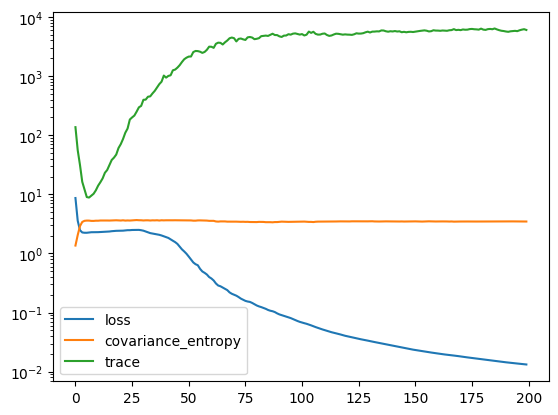

In [55]:
plt.plot(train_report.loss, label="loss")
plt.plot(train_report.covariance_entropy, label="covariance_entropy")
plt.plot(train_report.trace/5000, label="trace")
plt.yscale("log")
plt.legend()
plt.show()